# GRN Inference on sc-RNA Seq Data using CellOracle

In [1]:
import scanpy as sc
import pandas as pd

In [2]:
# Read the data
multiome_train = pd.read_parquet('data/multiome_train.parquet')
multiome_obs_meta = pd.read_csv('data/multiome_obs_meta.csv')
multiome_var_meta = pd.read_csv('data/multiome_var_meta.csv')

In [3]:
# Filter the var_meta to get only scRNA-seq locations (Gene Expression)
rna_var_meta = multiome_var_meta[multiome_var_meta['feature_type'] == 'Gene Expression']

# Use these Gene Expression locations to filter the train data
rna_data = multiome_train[multiome_train['location'].isin(rna_var_meta['location'])]

In [4]:
rna_data_pivot_count = rna_data.pivot(index='obs_id', columns='location', values='count')

In [5]:
import anndata as ad

# indices in obs_meta match the rows in rna_pivoted
obs_meta = multiome_obs_meta.set_index('obs_id').loc[rna_data_pivot_count.index]

# var_meta is ordered in the same way as columns in rna_pivoted
var_meta_ordered = rna_var_meta.set_index('location').loc[rna_data_pivot_count.columns]

rna_pivoted_filled = rna_data_pivot_count.fillna(0)

# create AnnData object
adata_rna = ad.AnnData(X=rna_pivoted_filled, obs=obs_meta, var=var_meta_ordered)

In [6]:
adata_rna.write('data/adata_rna_baseline.h5ad')

In [7]:
# Only consider genes with more than 1 count
sc.pp.filter_genes(adata_rna, min_counts=1)

In [8]:
# keep raw cont data before log transformation
adata_rna.raw = adata_rna
adata_rna.layers["raw_count"] = adata_rna.raw.X.copy()

In [10]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata_rna, key_n_counts='n_counts_all')

In [11]:
# Select top 3000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata_rna.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)

# Subset the genes
adata_rna = adata_rna[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata_rna)

/home/whd2108/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [12]:
# Log transformation and scaling
sc.pp.log1p(adata_rna)
sc.pp.scale(adata_rna)

In [13]:
# PCA
sc.tl.pca(adata_rna, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata_rna, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(adata_rna)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata_rna, n_neighbors=10, use_rep='X_diffmap')

In [14]:
sc.tl.louvain(adata_rna, resolution=0.8)

In [15]:
# PAGA graph construction
sc.tl.paga(adata_rna, groups='louvain')

In [16]:
%matplotlib inline 

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6, 4.5]

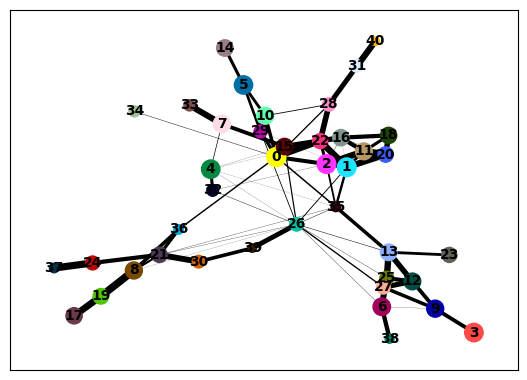

In [19]:
sc.pl.paga(adata_rna)

In [20]:
sc.tl.draw_graph(adata_rna, init_pos='paga', random_state=123)

/home/whd2108/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


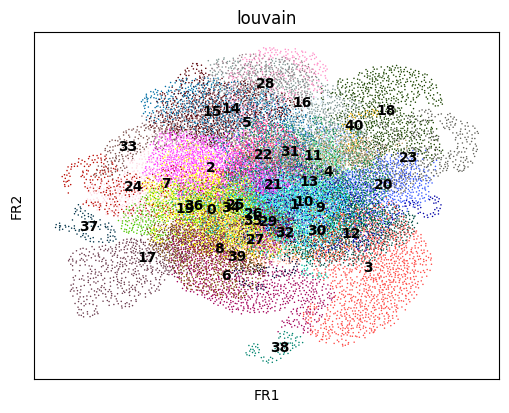

In [21]:
sc.pl.draw_graph(adata_rna, color='louvain', legend_loc='on data')

In [24]:
# Check current cluster name
cluster_list = adata_rna.obs.louvain.unique()
cluster_list

['17', '18', '7', '19', '15', ..., '34', '36', '37', '40', '39']
Length: 41
Categories (41, object): ['0', '1', '2', '3', ..., '37', '38', '39', '40']

In [29]:
import celloracle as co

/home/whd2108/.local/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/whd2108/.local/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/whd2108/.local/lib/python3.9/site-pa

In [30]:
# Load TF info which was made from human dataset.
base_GRN = co.data.load_human_promoter_base_GRN()

# Check data
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100027907_100029007,LOXL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100154964_100156064,MIR1287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100174878_100175978,PYROXD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100191017_100192117,MIR4685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100205078_100206178,LOC101927278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Instantiate Oracle object
oracle = co.Oracle()

In [32]:
# Check data in anndata
print("Metadata columns :", list(adata_rna.obs.columns))
print("Dimensional reduction: ", list(adata_rna.obsm.keys()))

Metadata columns : ['cell_type', 'donor_id', 'n_counts_all', 'n_counts', 'louvain']
Dimensional reduction:  ['X_pca', 'X_diffmap', 'X_draw_graph_fr']


In [33]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata_rna.X = adata_rna.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata_rna,
                                   cluster_column_name="louvain",
                                   embedding_name="X_draw_graph_fr")

In [34]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [35]:
import numpy as np

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

25


In [36]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :25551


In [37]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :638


In [38]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [39]:
# Save oracle object.
oracle.to_hdf5("adata_rna_final.celloracle.oracle")

In [40]:
# Check clustering data
sc.pl.draw_graph(oracle.adata, color="louvain")

In [41]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="louvain", alpha=10,
                         verbose_level=10)

  0%|          | 0/41 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 10...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 11...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 12...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 13...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 14...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 15...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 16...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 17...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 18...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 19...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 20...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 21...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 22...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 23...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 24...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 25...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 26...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 27...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 28...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 29...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 30...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 31...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 32...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 33...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 34...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 35...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 36...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 37...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 38...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 39...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 40...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 7...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 8...


  0%|          | 0/2259 [00:00<?, ?it/s]

Inferring GRN for 9...


  0%|          | 0/2259 [00:00<?, ?it/s]

CPU times: user 57min 56s, sys: 2min 37s, total: 1h 33s
Wall time: 1h 15min 37s


In [42]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [43]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=3000)

In [45]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 4.5]

0


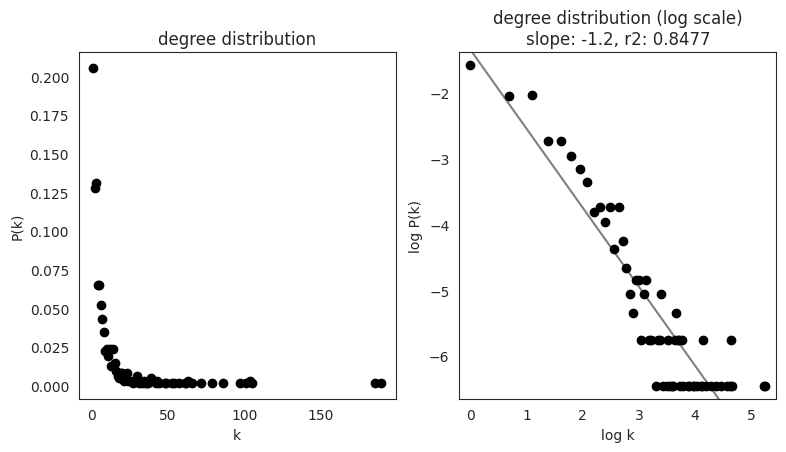

1


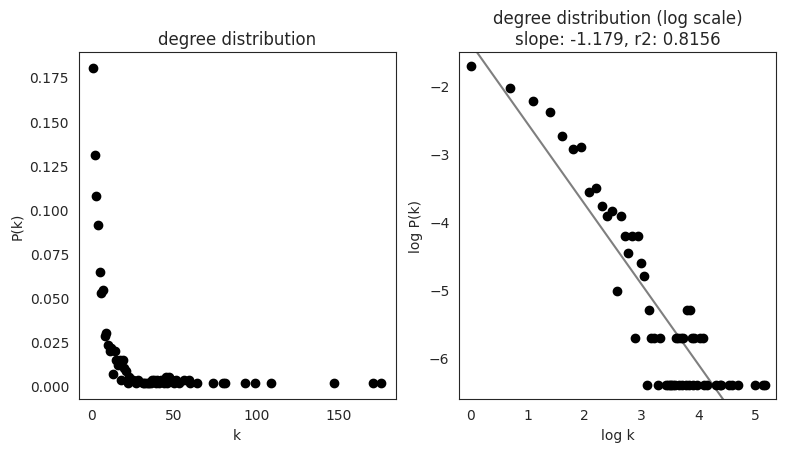

10


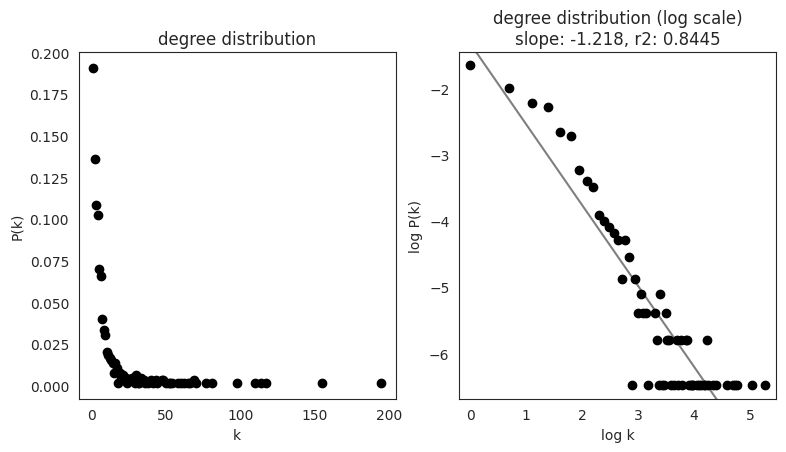

11


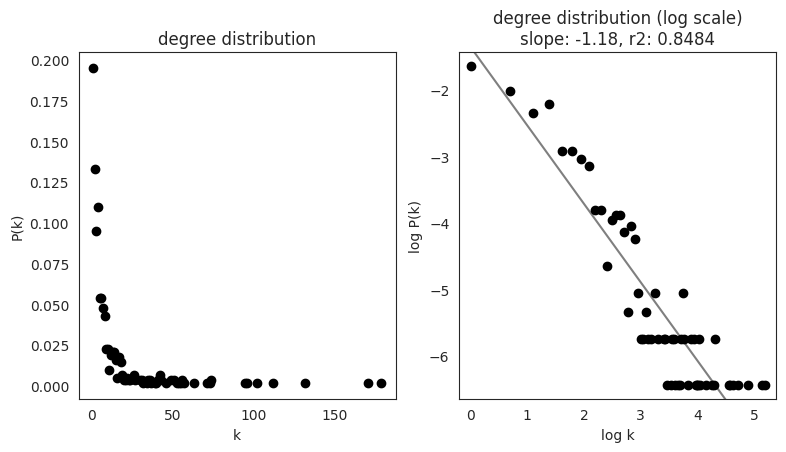

12


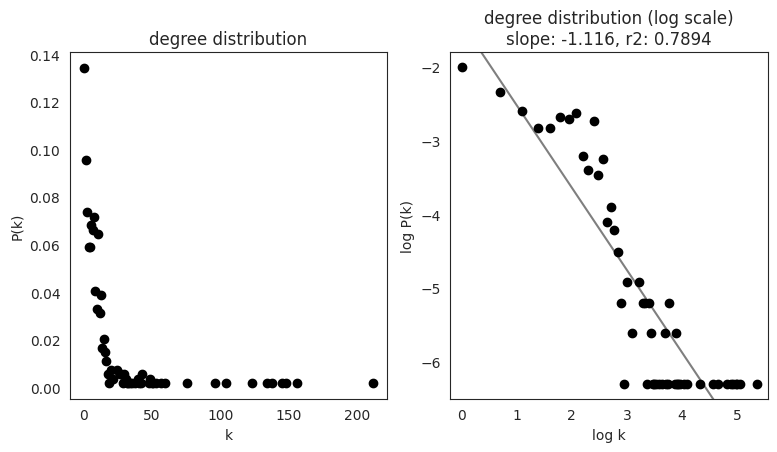

13


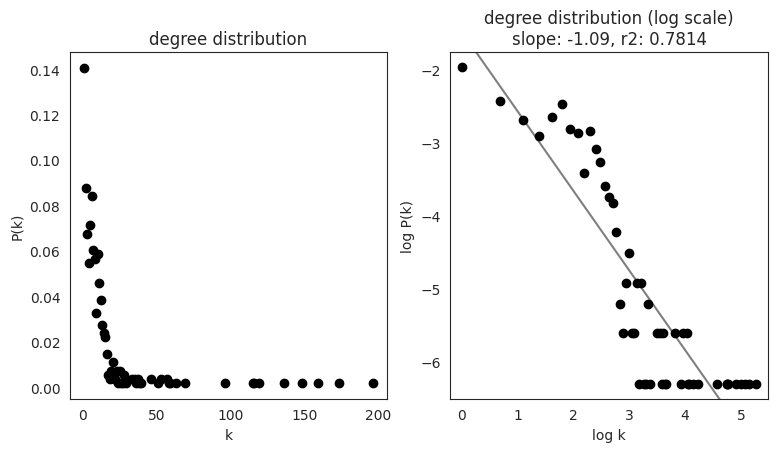

14


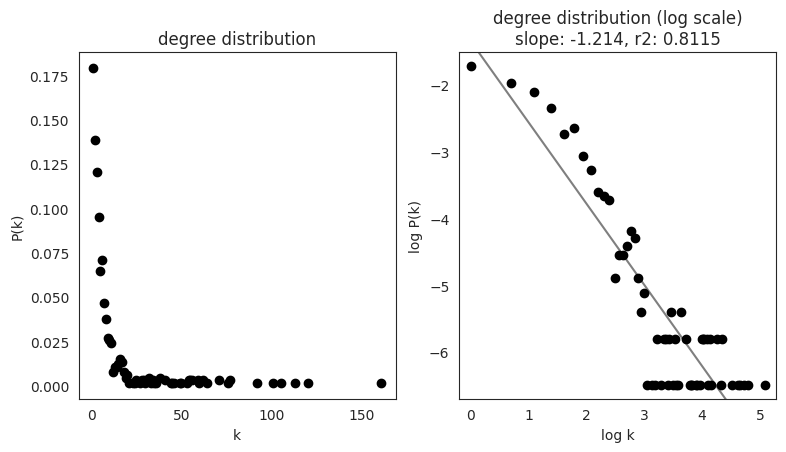

15


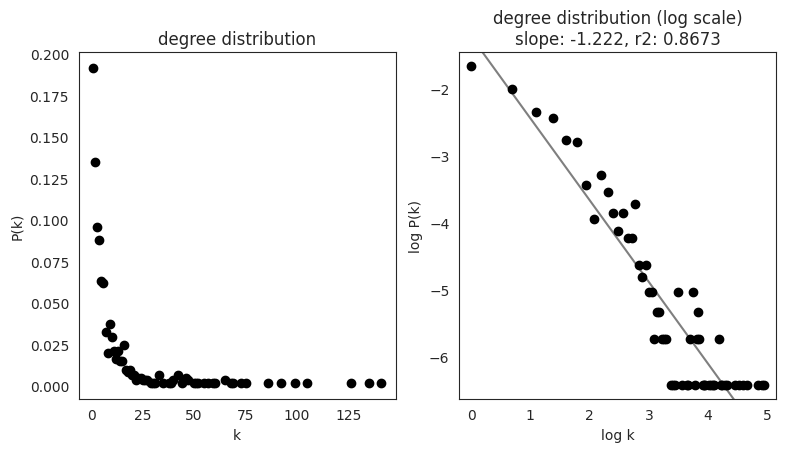

16


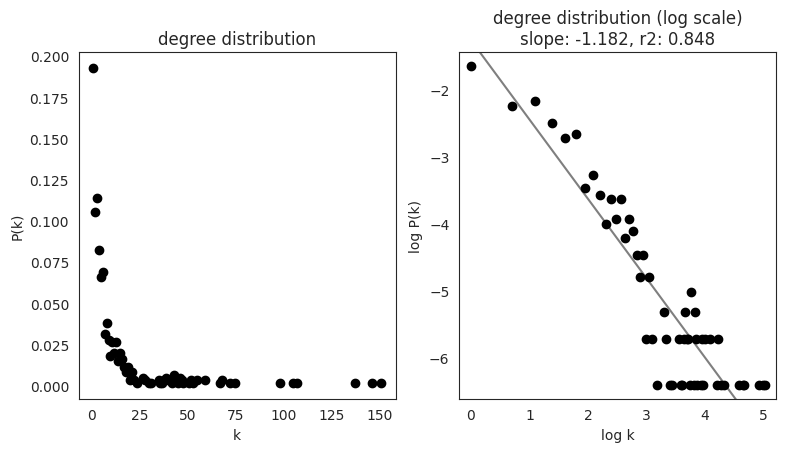

17


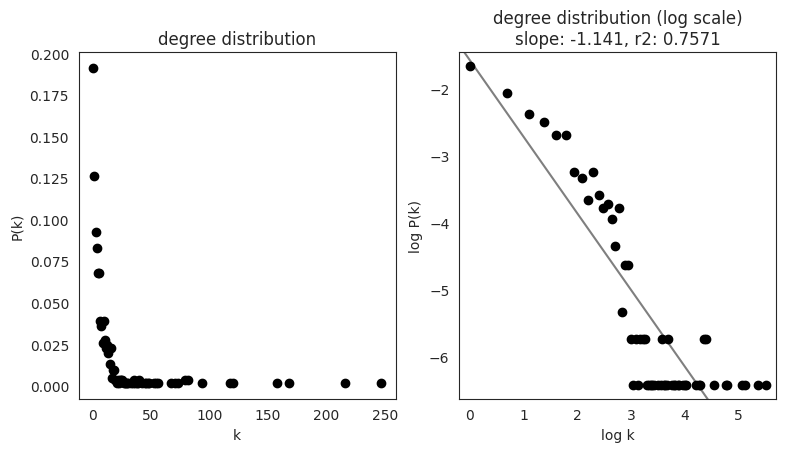

18


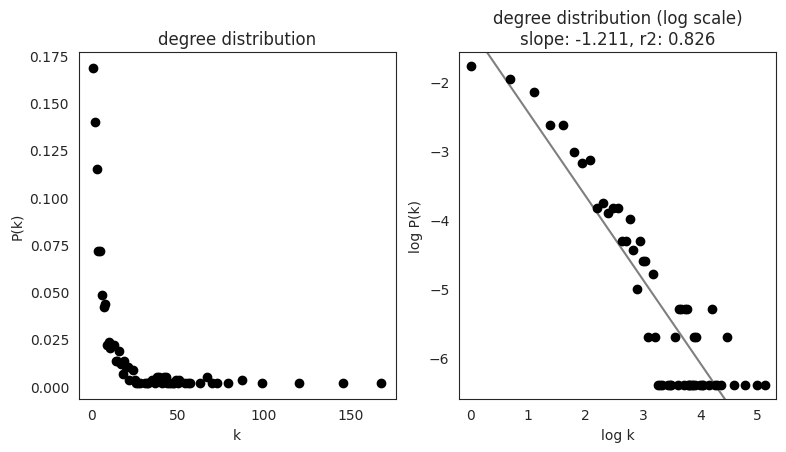

19


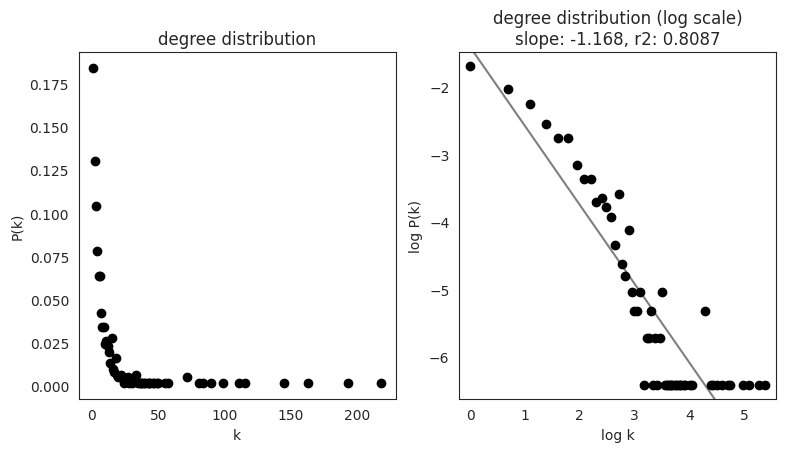

2


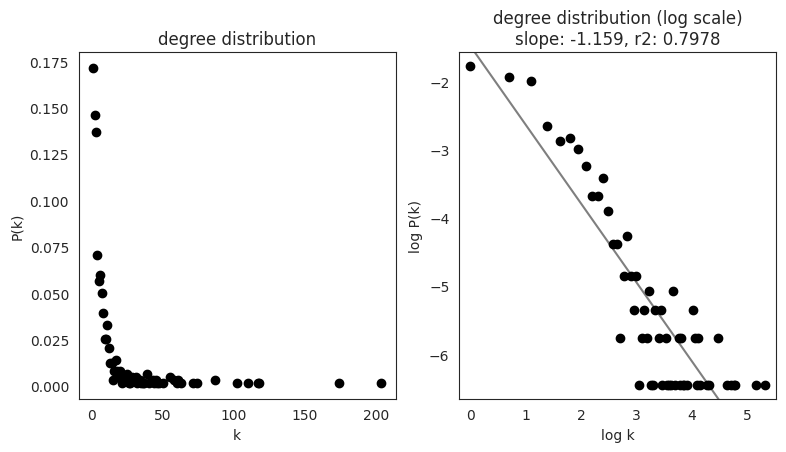

20


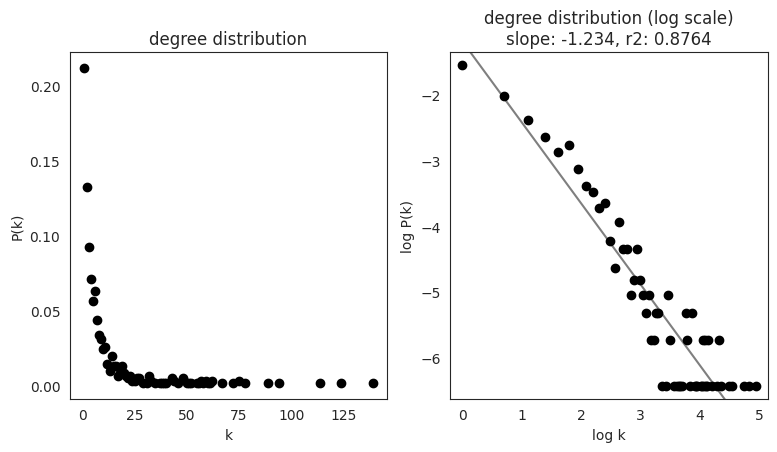

21


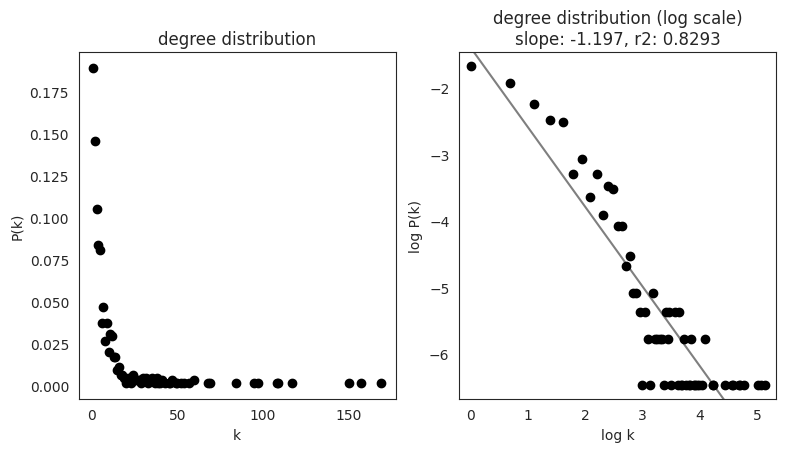

22


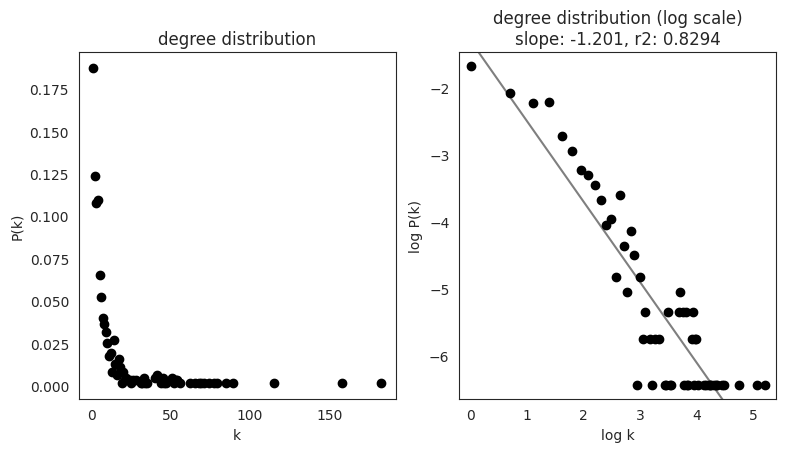

23


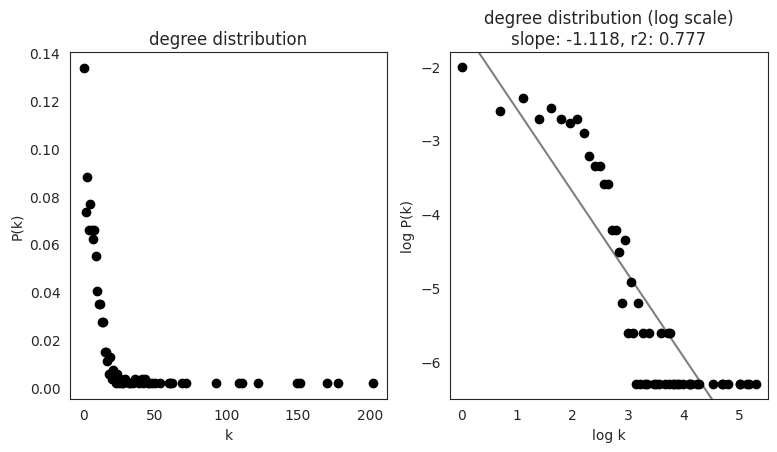

24


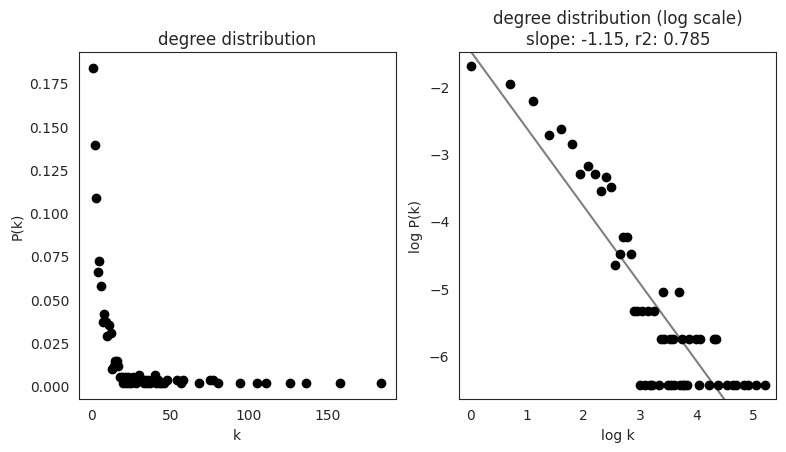

25


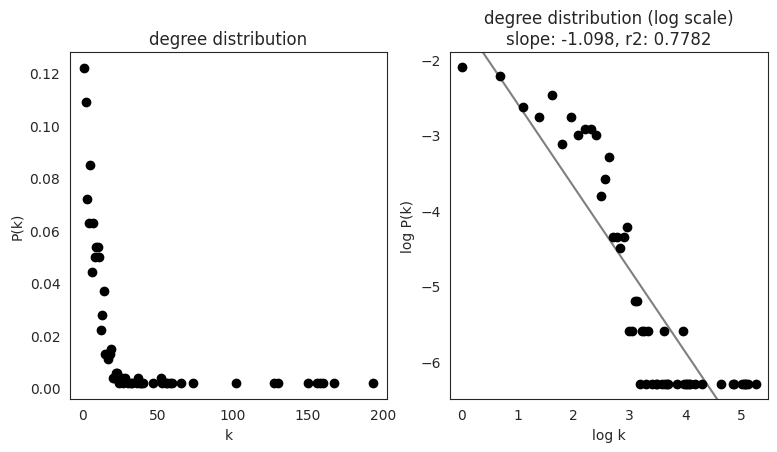

26


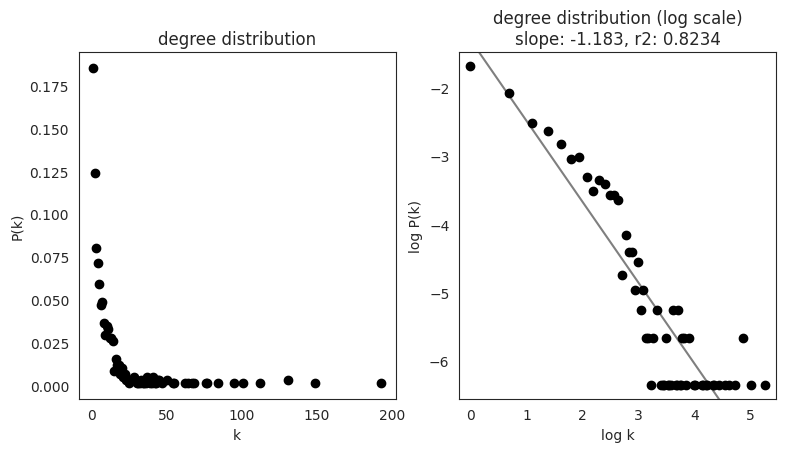

27


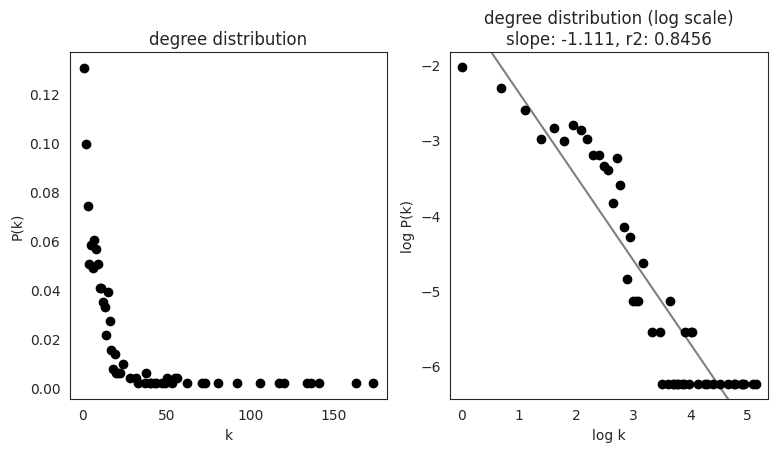

28


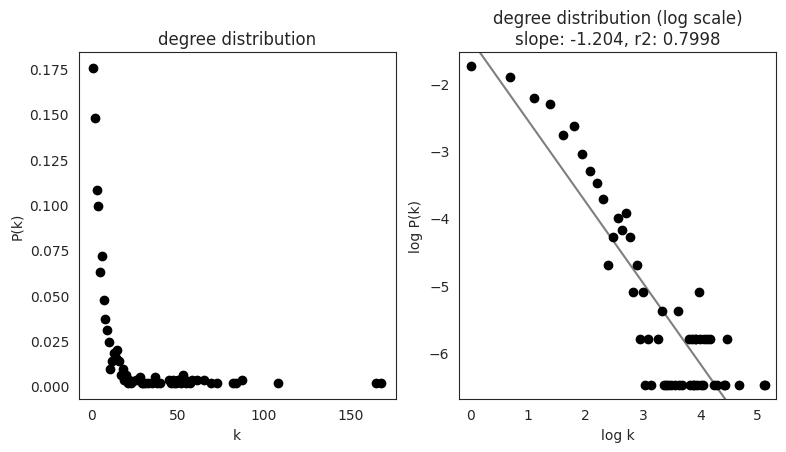

29


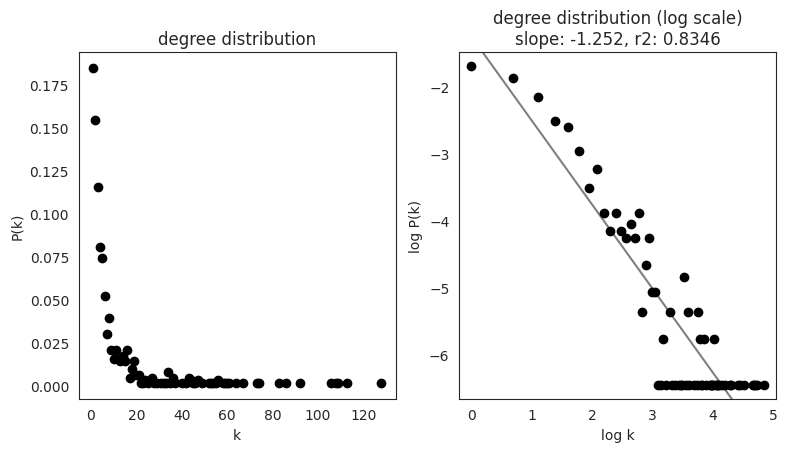

3


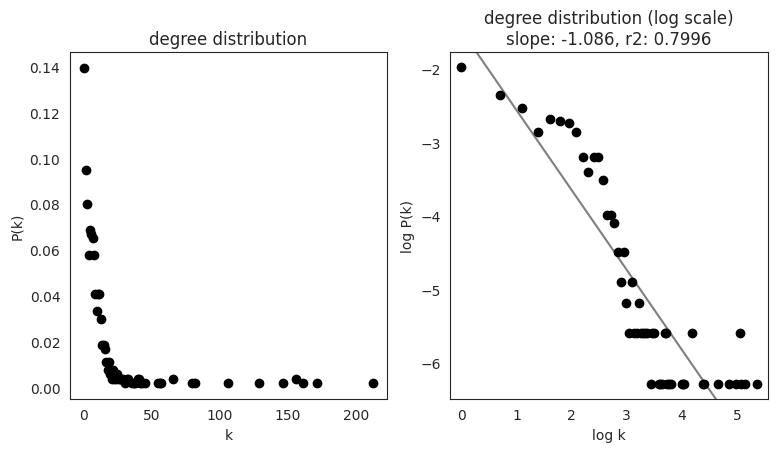

30


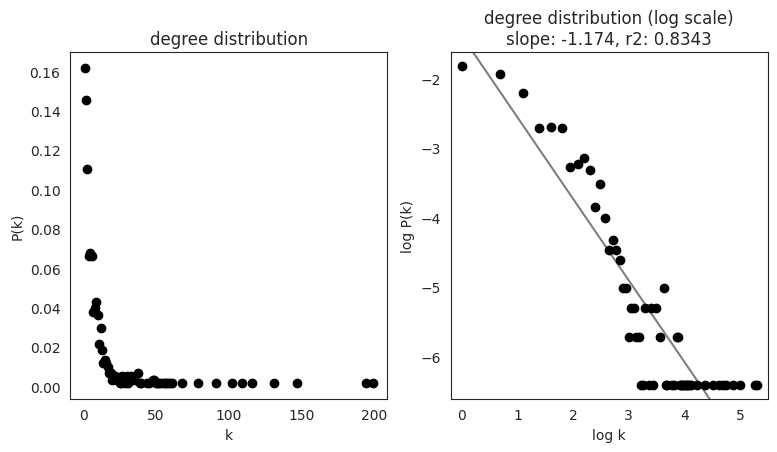

31


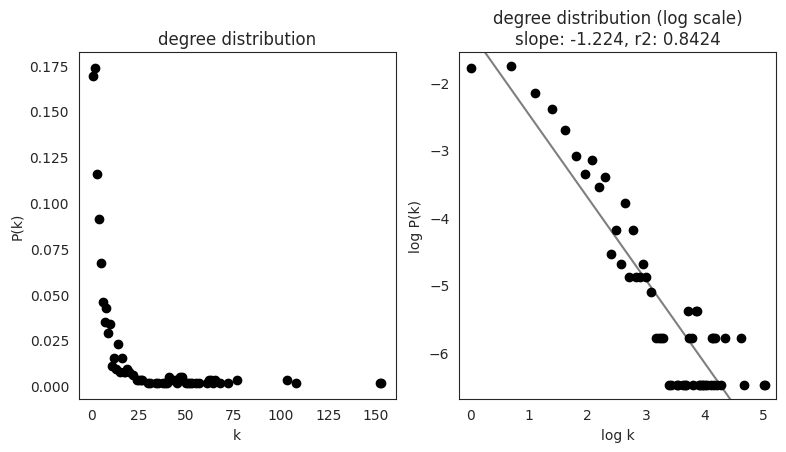

32


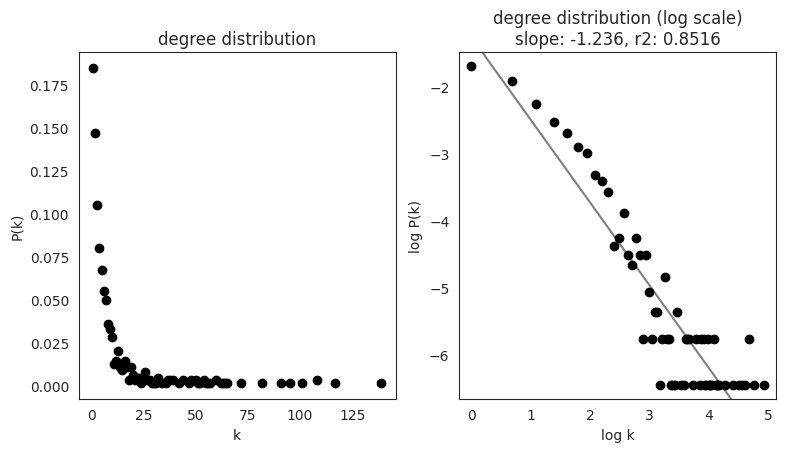

33


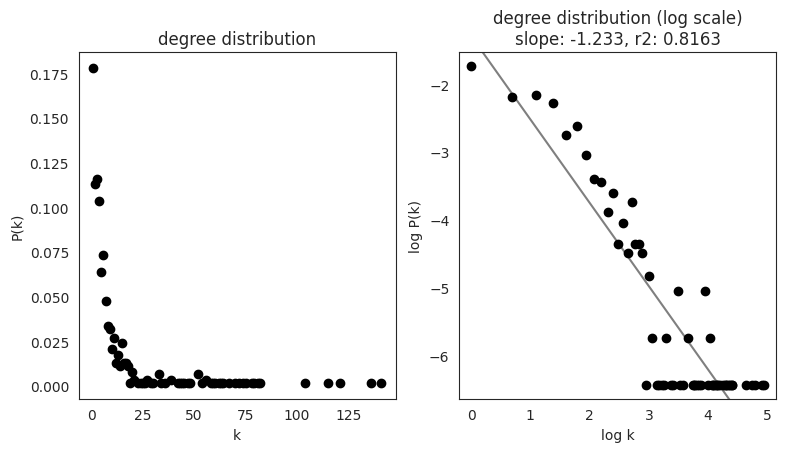

34


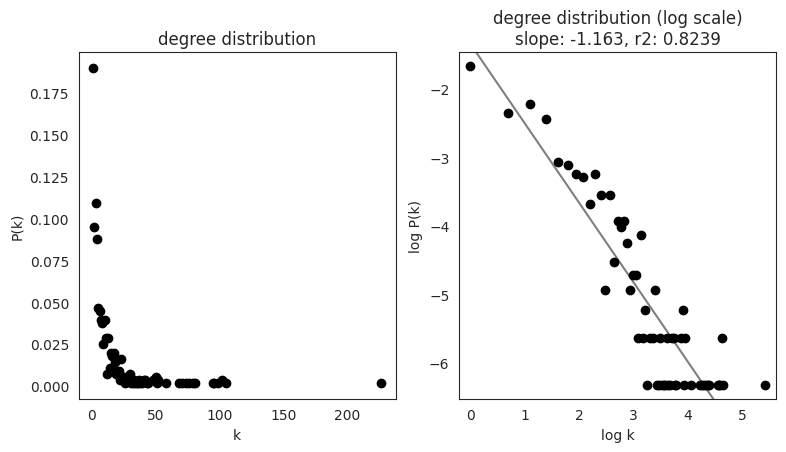

35


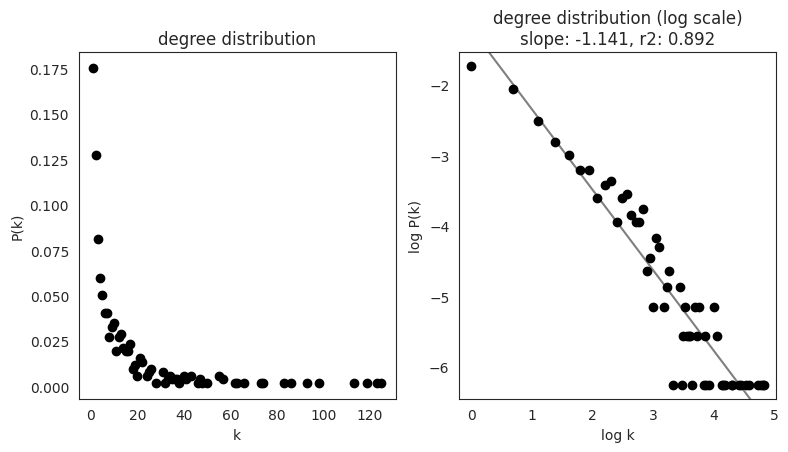

36


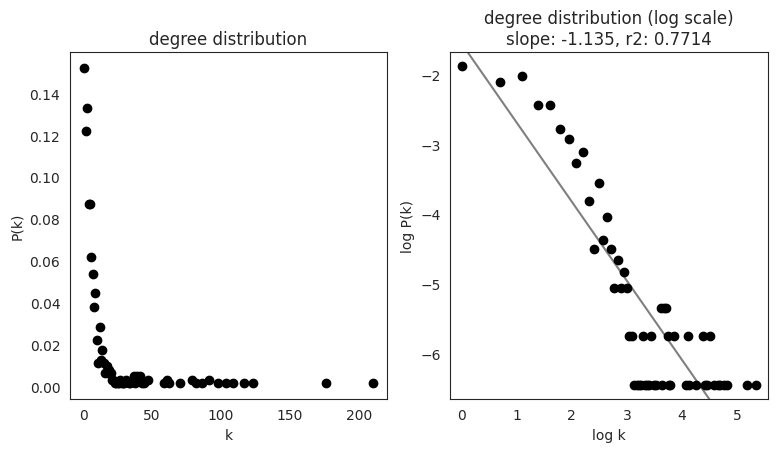

37


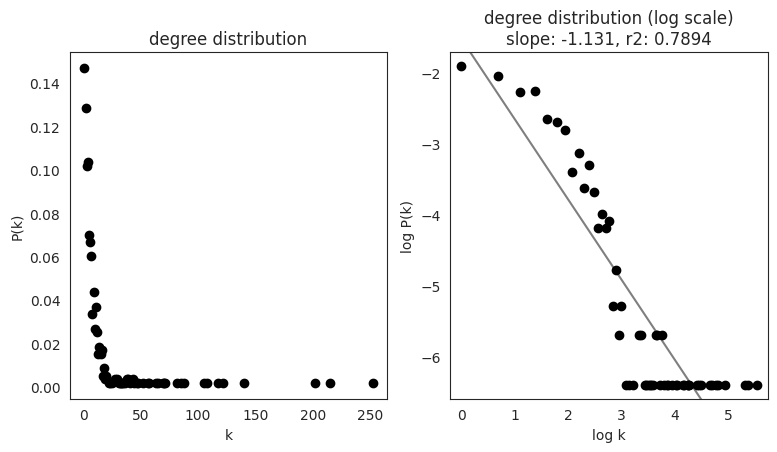

38


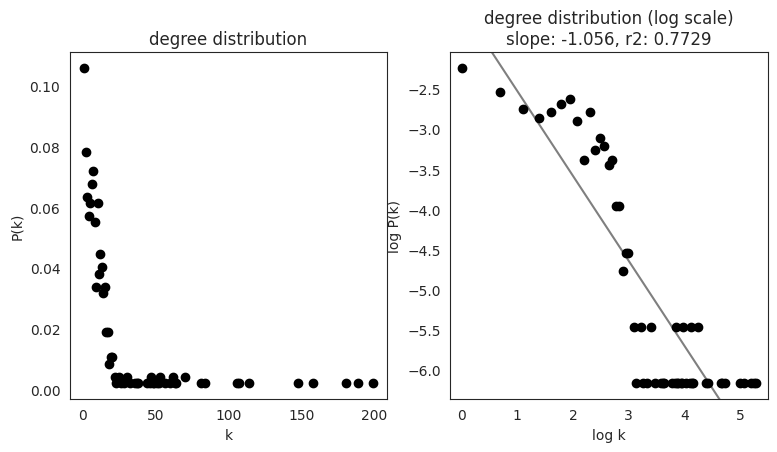

39


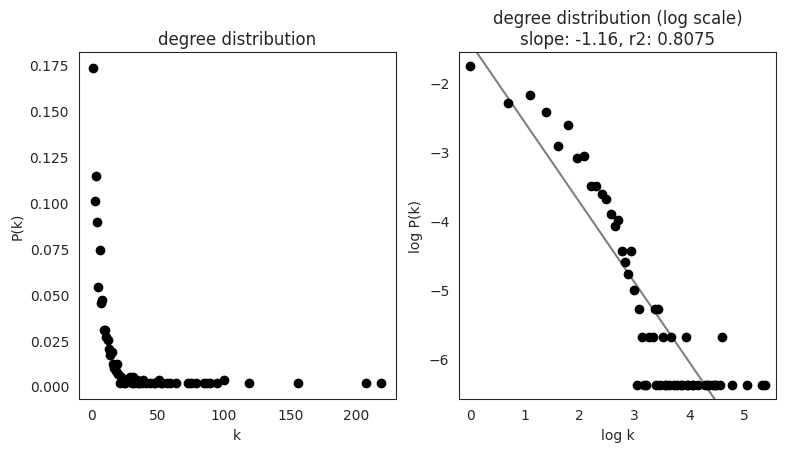

4


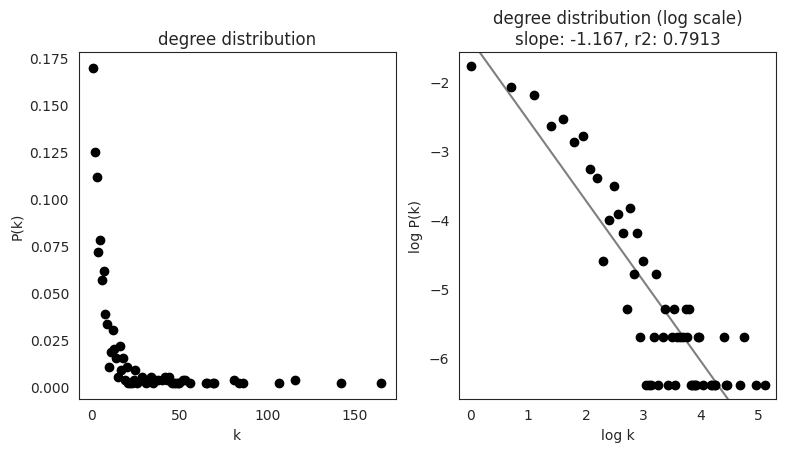

40


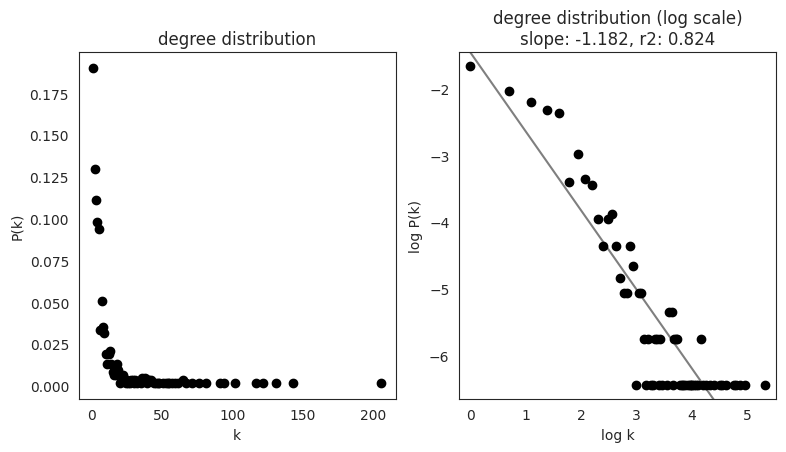

5


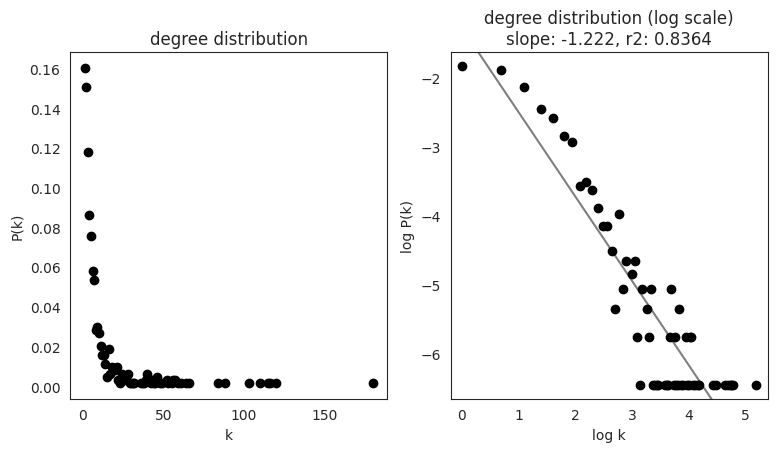

6


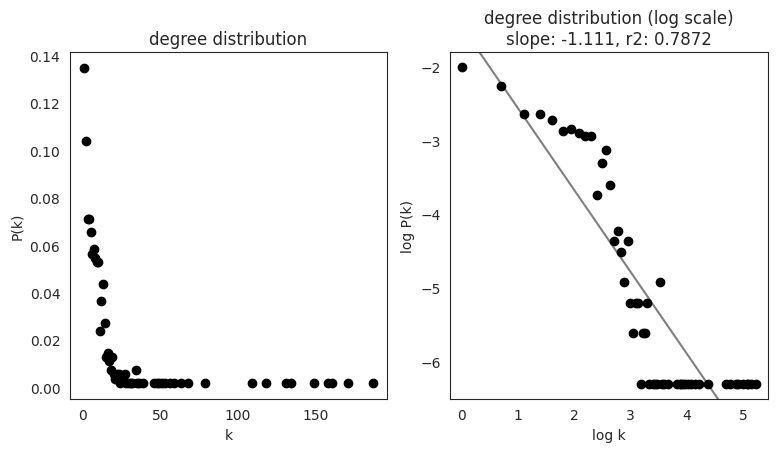

7


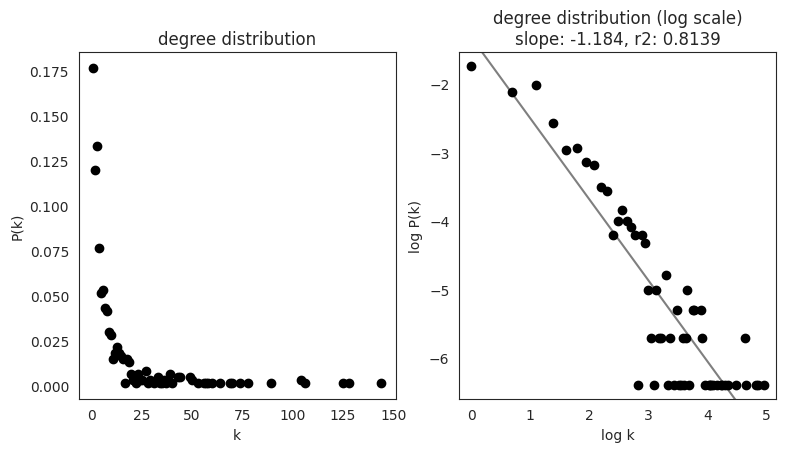

8


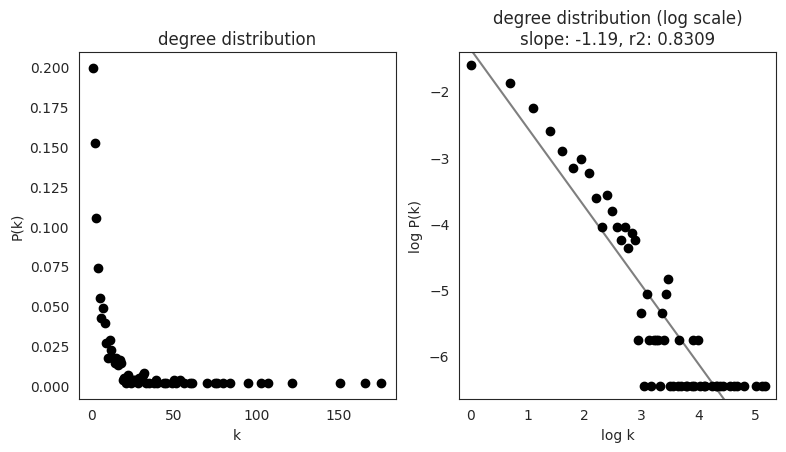

9


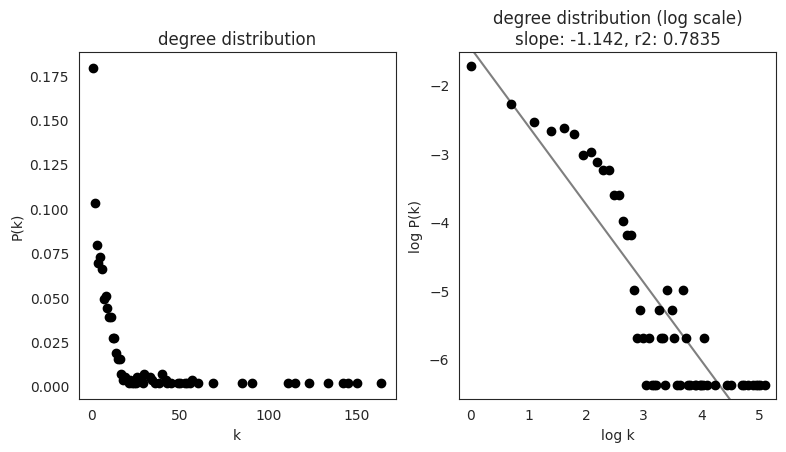

In [46]:
links.plot_degree_distributions(plot_model=True)

In [48]:
links.get_network_score()

In [54]:
links.merged_score

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
E2F5,101,0.159810,0,0.000000,101,0.159810,0.0,0.611977,0
RPLP1,6,0.009494,6,0.009494,0,0.000000,0.0,0.645849,0
MAFB,23,0.036392,2,0.003165,21,0.033228,3016.0,0.294707,0
RPL28,12,0.018987,12,0.018987,0,0.000000,0.0,0.337791,0
EGR1,97,0.153481,0,0.000000,97,0.153481,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...
CLMN,1,0.001692,1,0.001692,0,0.000000,0.0,0.001470,9
IRAK2,1,0.001692,1,0.001692,0,0.000000,0.0,0.003242,9
SELENOP,1,0.001692,1,0.001692,0,0.000000,0.0,0.003239,9
C11orf49,1,0.001692,1,0.001692,0,0.000000,0.0,0.000385,9


In [55]:
links.to_hdf5(file_path="links.celloracle.links")

In [56]:
links.cluster

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '5',
 '6',
 '7',
 '8',
 '9']

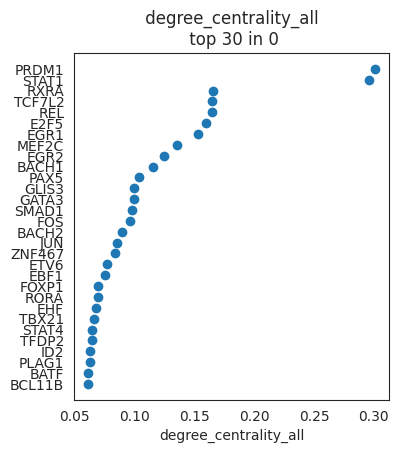

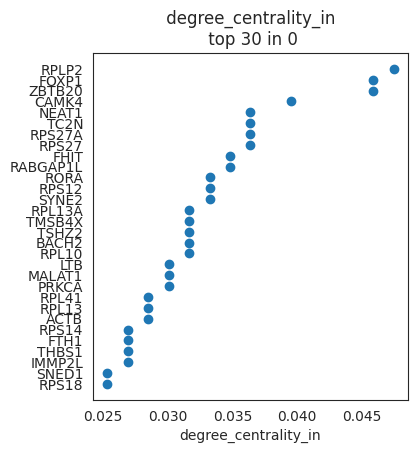

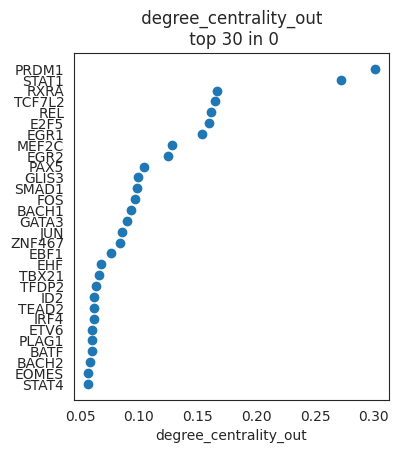

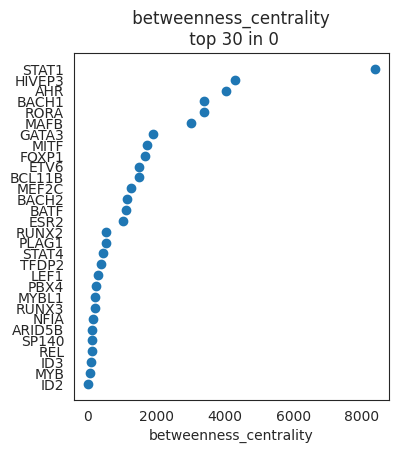

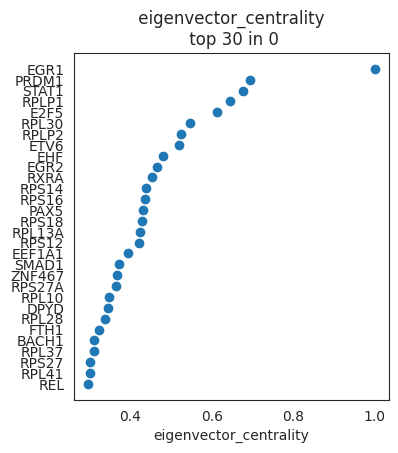

In [57]:
links.plot_scores_as_rank(cluster="0", n_gene=30)

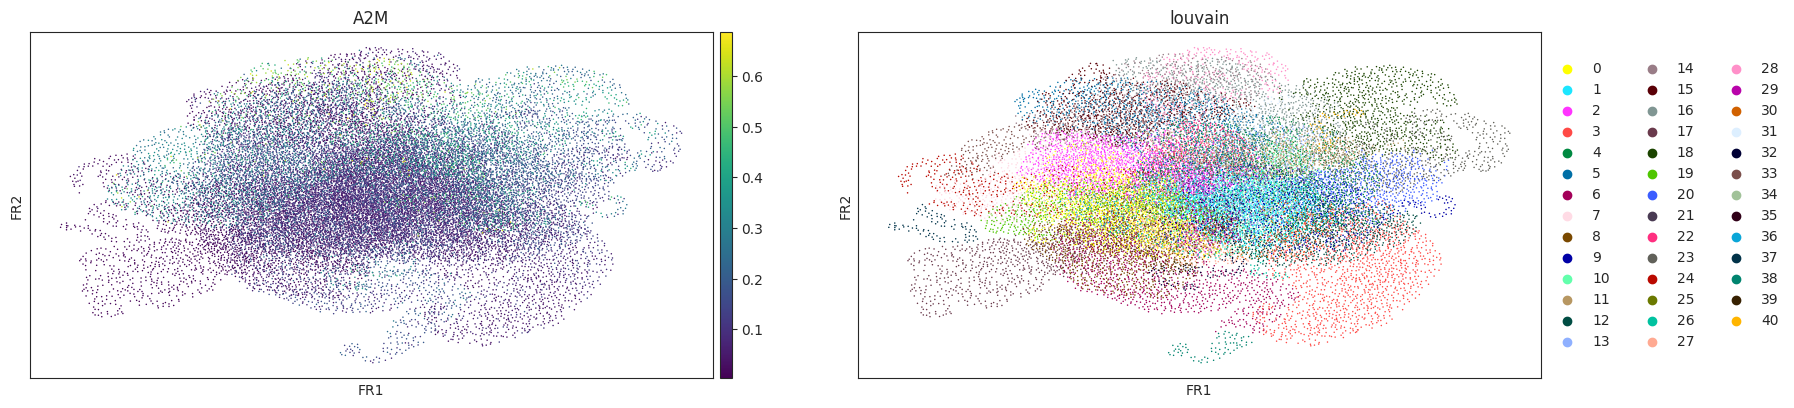

In [60]:
# Check gene expression
goi = "A2M"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")